In [1]:
# Full Startup Failure Analysis with Multiple Classifiers and NLP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from wordcloud import WordCloud
import re
import os
from PIL import ImageFont

In [2]:
import pandas as pd
import numpy as np
import os
import csv

# --- Step 1: Sanitize each CSV ---

def sanitize_csv(input_path, output_path, log_path=None):
    with open(input_path, 'r', encoding='utf-8') as infile, \
         open(output_path, 'w', newline='', encoding='utf-8') as outfile:

        reader = csv.reader(infile)
        writer = csv.writer(outfile)

        row_num = 0
        bad_rows = []
        expected_len = None

        for row in reader:
            row_num += 1
            if expected_len is None:
                expected_len = len(row)
                writer.writerow(row)
                continue

            if len(row) == expected_len:
                writer.writerow(row)
            else:
                bad_rows.append(row_num)

    if log_path:
        with open(log_path, 'a') as log:
            log.write(f"{os.path.basename(input_path)}: Dropped lines {bad_rows}\n")

# --- File paths ---

base_dir = "/Users/HP/Documents/USA_Docs/Final_docs_USA/NEU Final Docs/SML/Project/"
clean_dir = os.path.join(base_dir, "CleanedCSVs")
os.makedirs(clean_dir, exist_ok=True)
log_file = os.path.join(clean_dir, "sanitization_log.txt")

file_paths = {
    "Finance and Insurance": "Startup Failure (Finance and Insurance).csv",
    "Retail Trade": "Startup Failures (Retail Trade).csv",
    "Food and Services": "Startup Failure (Food and services).csv",
    "Manufactures": "Startup Failure (Manufactures).csv",
    "Information Sector": "Startup Failures (Information Sector).csv",
    "Health Care": "Startup Failure (Health Care).csv"
}

# Sanitize files
cleaned_paths = {}
for sector, filename in file_paths.items():
    raw_path = os.path.join(base_dir, filename)
    clean_path = os.path.join(clean_dir, f"cleaned_{filename}")
    sanitize_csv(raw_path, clean_path, log_file)
    cleaned_paths[sector] = clean_path

# --- Step 2: Load, tag, and preprocess combined data ---

combined_dataframes = []
for sector, path in cleaned_paths.items():
    df = pd.read_csv(path)
    df["Source Sector"] = sector
    combined_dataframes.append(df)

df_combined = pd.concat(combined_dataframes, ignore_index=True)

# Drop obviously bad or empty columns
columns_to_drop = [col for col in df_combined.columns if 'Name,Sector' in col or df_combined[col].isnull().sum() == len(df_combined)]
df_combined.drop(columns=columns_to_drop, inplace=True)

# Strip whitespace from column names
df_combined.columns = [col.strip() for col in df_combined.columns]

# Extract start and end year from 'Years of Operation'
def extract_years(op_string):
    if isinstance(op_string, str) and '(' in op_string and ')' in op_string:
        try:
            years = op_string.split('(')[1].split(')')[0]
            start, end = years.split('-')
            return int(start), int(end)
        except:
            return np.nan, np.nan
    return np.nan, np.nan

df_combined[['Start Year', 'End Year']] = df_combined['Years of Operation'].apply(
    lambda x: pd.Series(extract_years(x))
)

# Convert funding strings like "$15M" to numbers
def convert_funding(val):
    try:
        val = val.replace('$', '').replace(',', '').upper()
        if 'M' in val:
            return float(val.replace('M', '')) * 1e6
        elif 'B' in val:
            return float(val.replace('B', '')) * 1e9
        else:
            return float(val)
    except:
        return np.nan

df_combined['Funding Amount'] = df_combined['How Much They Raised'].apply(convert_funding)

# Clean text columns
for text_col in ['What They Did', 'Why They Failed', 'Takeaway']:
    df_combined[text_col] = df_combined[text_col].astype(str).str.strip().str.lower()

# Drop rows missing key identifiers
df_combined.dropna(subset=["Name", "Sector", "Why They Failed"], how='all', inplace=True)

# Save final output
output_file = os.path.join(base_dir, "Preprocessed_Startup_Data.csv")
df_combined.to_csv(output_file, index=False)

print("✅ All CSVs sanitized and combined successfully.")
print(f"🧼 Log saved to: {log_file}")
print(f"📁 Final output: {output_file}")


✅ All CSVs sanitized and combined successfully.
🧼 Log saved to: /Users/HP/Documents/USA_Docs/Final_docs_USA/NEU Final Docs/SML/Project/CleanedCSVs\sanitization_log.txt
📁 Final output: /Users/HP/Documents/USA_Docs/Final_docs_USA/NEU Final Docs/SML/Project/Preprocessed_Startup_Data.csv


In [3]:
combined_df=df_combined

In [4]:
# Data Cleaning

def clean_funding(val):
    if isinstance(val, str):
        val = re.sub(r'\([^)]*\)', '', val)
        val = val.upper().replace('$','').replace(',','').strip()
        match = re.search(r'\d+(\.\d+)?', val)
        if not match:
            return np.nan
        num = float(match.group())
        if 'M' in val:
            return num * 1e6
        elif 'B' in val:
            return num * 1e9
        else:
            return num
    return np.nan

combined_df['Funding Amount'] = combined_df['How Much They Raised'].apply(clean_funding)

def extract_years_safe(op_string):
    try:
        if isinstance(op_string, str):
            op_string = re.sub(r'\([^)]*\)', '', op_string)
            parts = re.findall(r'\d{4}', op_string)
            if len(parts) >= 2:
                return int(parts[0]), int(parts[1])
    except:
        pass
    return np.nan, np.nan

combined_df[['Start Year', 'End Year']] = combined_df['Years of Operation'].apply(
    lambda x: pd.Series(extract_years_safe(x))
)

combined_df = combined_df.loc[:, ~combined_df.columns.str.contains('^Unnamed')]
binary_cols = [col for col in combined_df.select_dtypes(include=[np.number]).columns if col != 'Overhype']
combined_df[binary_cols] = combined_df[binary_cols].fillna(0)



C:\Users\HP\anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [5]:
# Feature Engineering
model_df = combined_df.dropna(subset=['Overhype'])
model_df['Funding Bucket'] = pd.cut(model_df['Funding Amount'], bins=[-1, 1e6, 1e7, 1e8, 1e9, np.inf], labels=['<1M', '1M-10M', '10M-100M', '100M-1B', '>1B'])
x_numeric_base = ['Start Year', 'End Year'] + [col for col in binary_cols if col in model_df.columns and col not in ['Funding Amount']]
x_numeric = list(dict.fromkeys(x_numeric_base))
x_categorical = ['Funding Bucket']
features = x_categorical + x_numeric
y = (model_df['Overhype'] > 0.5).astype(int)
X = model_df[features]

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', sparse_output=False), x_categorical),
    ('num', StandardScaler(), x_numeric)
])

X_processed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)
X_train_bal, y_train_bal = SMOTE(random_state=42).fit_resample(X_train, y_train)



<ipython-input-5-87b986b9f589>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['Funding Bucket'] = pd.cut(model_df['Funding Amount'], bins=[-1, 1e6, 1e7, 1e8, 1e9, np.inf], labels=['<1M', '1M-10M', '10M-100M', '100M-1B', '>1B'])


In [6]:
# Classifiers
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Support Vector Machine": SVC(probability=True)
}

for name, model in models.items():
    model.fit(X_train_bal, y_train_bal)
    preds = model.predict(X_test)
    print(f"\n{name} Accuracy: {accuracy_score(y_test, preds):.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, preds))
    print("Classification Report:\n", classification_report(y_test, preds))



Random Forest Accuracy: 0.9500
Confusion Matrix:
 [[57  0]
 [ 3  0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        57
           1       0.00      0.00      0.00         3

    accuracy                           0.95        60
   macro avg       0.47      0.50      0.49        60
weighted avg       0.90      0.95      0.93        60


Logistic Regression Accuracy: 0.7500
Confusion Matrix:
 [[42 15]
 [ 0  3]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.74      0.85        57
           1       0.17      1.00      0.29         3

    accuracy                           0.75        60
   macro avg       0.58      0.87      0.57        60
weighted avg       0.96      0.75      0.82        60


Decision Tree Accuracy: 0.9333
Confusion Matrix:
 [[56  1]
 [ 3  0]]
Classification Report:
               precision    recall  f1-score   support

   

C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [7]:
# NLP Analysis on 'Why They Failed'
text_df = combined_df.dropna(subset=['Why They Failed'])
tfidf = TfidfVectorizer(max_features=100, stop_words='english')
X_text = tfidf.fit_transform(text_df['Why They Failed'])
keywords = tfidf.get_feature_names_out()
sums = X_text.sum(axis=0).A1
keyword_freq = pd.DataFrame({'keyword': keywords, 'frequency': sums}).sort_values(by='frequency', ascending=False)

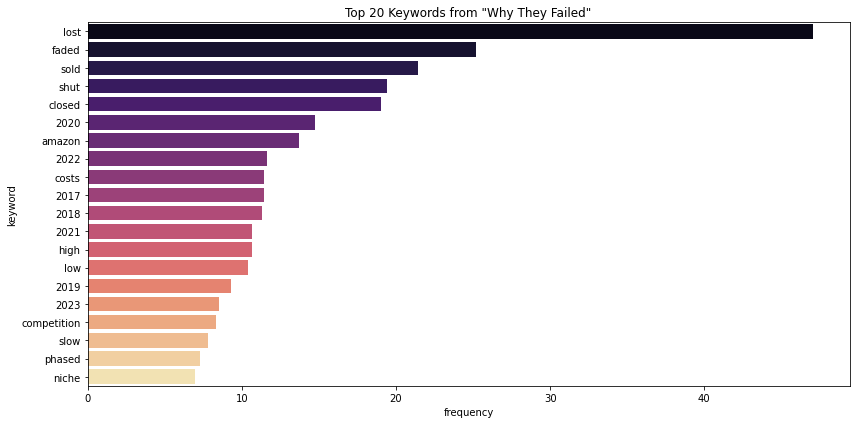

In [8]:
# Plot Top Keywords
plt.figure(figsize=(12,6))
sns.barplot(data=keyword_freq.head(20), x='frequency', y='keyword', palette='magma')
plt.title('Top 20 Keywords from "Why They Failed"')
plt.tight_layout()
plt.show()



In [17]:
#!pip install Pillow==9.5.0

  Attempting uninstall: Pillow
    Found existing installation: Pillow 8.0.1
    Uninstalling Pillow-8.0.1:
      Successfully uninstalled Pillow-8.0.1


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'C:\\Users\\HP\\anaconda3\\Lib\\site-packages\\~il\\_imaging.cp38-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



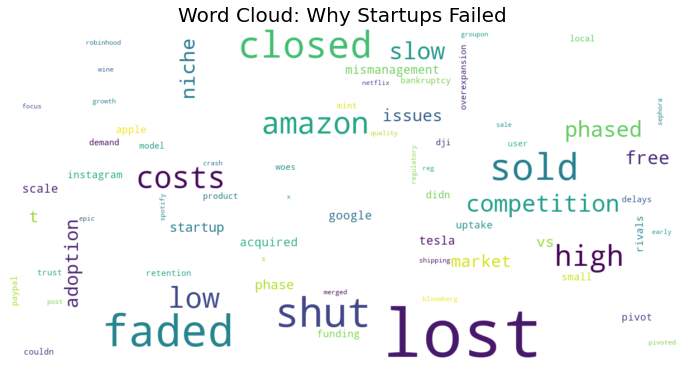

In [9]:
# Word Cloud Fix
# Word Cloud Fix
# Tokenizing for word cloud
wordcloud_df = pd.DataFrame()
wordcloud_df['tokens'] = text_df['Why They Failed'].dropna().astype(str).apply(lambda x: x.split())

def show_wordcloud(data, title=None):
    text = ' '.join([' '.join(tokens) for tokens in data])
    wordcloud = WordCloud(
        background_color='white',
        max_words=300,
        max_font_size=40,
        scale=3,
        random_state=1,
        collocations=False
    ).generate(text)
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title:
        plt.title(title, fontsize=20)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()

show_wordcloud(wordcloud_df['tokens'], title='Word Cloud: Why Startups Failed')



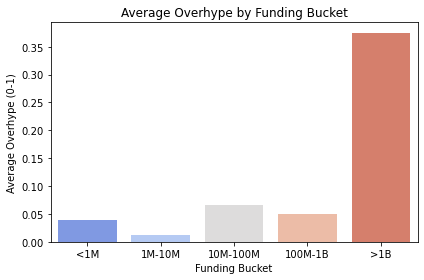

In [10]:
# Plot Funding Bucket vs Overhype
bucket_vs_hype = model_df.groupby('Funding Bucket')['Overhype'].mean().reset_index()
sns.barplot(data=bucket_vs_hype, x='Funding Bucket', y='Overhype', palette='coolwarm')
plt.title('Average Overhype by Funding Bucket')
plt.ylabel('Average Overhype (0-1)')
plt.xlabel('Funding Bucket')
plt.tight_layout()
plt.show()

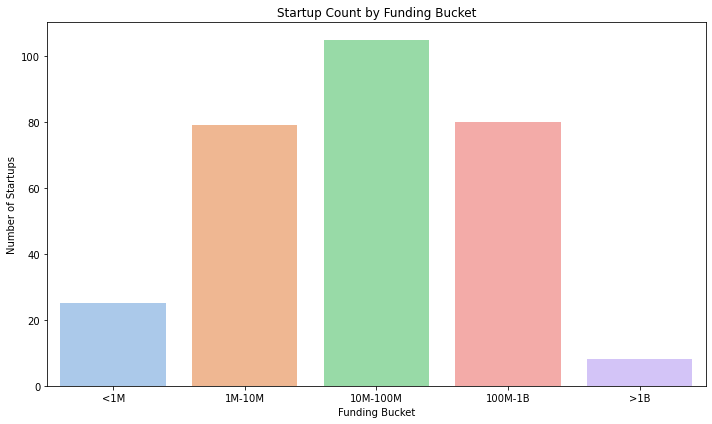

In [11]:
# Plot Funding Bucket vs Overhype

# Additional Visualizations
# 1. Countplot of startups by Funding Bucket
plt.figure(figsize=(10, 6))
sns.countplot(data=model_df, x='Funding Bucket', palette='pastel')
plt.title('Startup Count by Funding Bucket')
plt.xlabel('Funding Bucket')
plt.ylabel('Number of Startups')
plt.tight_layout()
plt.show()

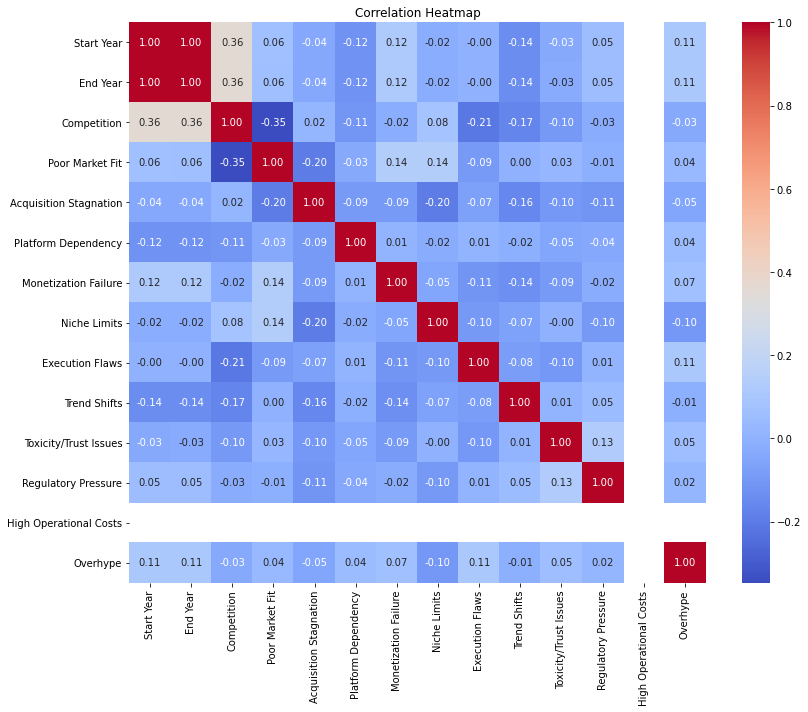

In [12]:
# 2. Heatmap of correlations
plt.figure(figsize=(12, 10))
corr_matrix = model_df[x_numeric + ['Overhype']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

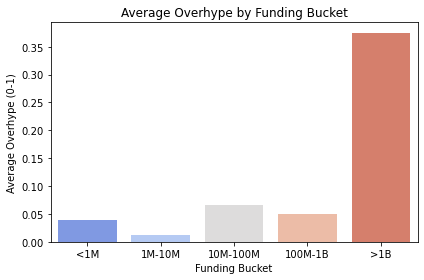

In [13]:
# plot for Funding Amount vs Overhype
bucket_vs_hype = model_df.groupby('Funding Bucket')['Overhype'].mean().reset_index()
sns.barplot(data=bucket_vs_hype, x='Funding Bucket', y='Overhype', palette='coolwarm')
plt.title('Average Overhype by Funding Bucket')
plt.ylabel('Average Overhype (0-1)')
plt.xlabel('Funding Bucket')
plt.tight_layout()
plt.show()

In [14]:

# Step: Handling Class Imbalance with SMOTE and Evaluating Models

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
import numpy as np

# Ensure X_processed and y are already defined in your notebook before this block
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.3, random_state=42, stratify=y)

# Apply SMOTE on training data
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Define weighted classifiers
models = {
    "Random Forest (weighted)": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "Logistic Regression (weighted)": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Decision Tree (weighted)": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    print(f"\nModel: {name}")
    model.fit(X_train_bal, y_train_bal)
    preds = model.predict(X_test)
    cm = confusion_matrix(y_test, preds)
    cr = classification_report(y_test, preds)
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(cr)
    
    results[name] = {
        "Accuracy": accuracy_score(y_test, preds),
        "Confusion Matrix": cm,
        "Classification Report": classification_report(y_test, preds, output_dict=True)
    }

# Summarize performance
summary_df = pd.DataFrame({
    model: {
        "Accuracy": round(metrics["Accuracy"], 3),
        "Recall (Class 1)": round(metrics["Classification Report"].get("1", {}).get("recall", np.nan), 3),
        "Precision (Class 1)": round(metrics["Classification Report"].get("1", {}).get("precision", np.nan), 3)
    }
    for model, metrics in results.items()
}).T

print("\nModel Evaluation Summary:")
print(summary_df)



Model: Random Forest (weighted)
Confusion Matrix:
[[84  1]
 [ 2  3]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98        85
           1       0.75      0.60      0.67         5

    accuracy                           0.97        90
   macro avg       0.86      0.79      0.82        90
weighted avg       0.96      0.97      0.96        90


Model: Logistic Regression (weighted)
Confusion Matrix:
[[64 21]
 [ 1  4]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.75      0.85        85
           1       0.16      0.80      0.27         5

    accuracy                           0.76        90
   macro avg       0.57      0.78      0.56        90
weighted avg       0.94      0.76      0.82        90


Model: Decision Tree (weighted)
Confusion Matrix:
[[81  4]
 [ 2  3]]
Classification Report:
              precision    recall  f1-score   support

      